In [2]:
import mne
import os
import pywt
from skimage.restoration import denoise_wavelet
import warnings
warnings.filterwarnings('ignore')
from os.path import abspath
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mne.time_frequency import psd_welch
from tqdm import tqdm
import itertools
import pickle 
from multiprocessing import Process
file_path="/media/kashraf/Elements/Dissertation/data/CVPIA_eeg/Data/Filtered/S2/"
filename=os.listdir(file_path)
path_montage="/media/kashraf/Elements/data_gen_may_2021/montage/"
montage=mne.channels.read_montage(path_montage+"//"+"neuroscan64ch.loc")
data1=mne.io.read_raw_cnt(file_path+"S02_v Data.cnt",montage=montage, 
                         preload=True,verbose=False);

good_ch= mne.pick_channels(data1.info['ch_names'], include=[],
                        exclude=["EKG","EMG",'VEO','HEO','Trigger'])
mne.pick_info(data1.info,sel=good_ch,copy=False,verbose=False)
data1.set_montage(montage)
mne.pick_info(data1.info,sel=good_ch,copy=False)
data1.set_montage(montage)

<RawCNT  |  S02_v Data.cnt, n_channels x n_times : 64 x 525925 (2103.7 sec), ~277.0 MB, data loaded>

In [3]:
data1

<RawCNT  |  S02_v Data.cnt, n_channels x n_times : 64 x 525925 (2103.7 sec), ~277.0 MB, data loaded>

In [4]:
def read_load_type(data_path,dest_path=None,stim_type=None):
    folders = os.listdir(data_path)
    audio,visual, audio_visual = [],[],[]
    for folder in folders: 
        fnames = os.listdir(os.path.join(data_path,folder))
        # Let's go through the folders
        for f in fnames:
            if f.endswith("a Data.cnt"):
                audio.append(os.path.join(data_path,folder,f))
            elif f.endswith("av Data.cnt"):
                audio_visual.append(os.path.join(data_path,folder,f))
                
            elif f.endswith("v Data.cnt"):
                visual.append(os.path.join(data_path,folder,f))
    return audio,audio_visual,visual
                
                
path = "/media/kashraf/Elements/Dissertation/data/CVPIA_eeg/Data/Filtered"
a,av,v=read_load_type(path)

In [5]:
import shutil
dest_path="/media/kashraf/Elements/Dissertation/data/CVPIA_eeg/Data/Cnt_files"
for file in tqdm(av):
    shutil.copy(file,os.path.join(dest_path,"audio-visual",file[-15:]))
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:52<00:00,  3.74s/it]


In [6]:
av[0][-15:]

'S01_av Data.cnt'

## Loading the data

In [7]:
visual=[mne.io.read_raw_cnt(file,preload=True,verbose=0)
             for file in tqdm(a)]
bad_chs=["EKG","EMG",'VEO','HEO','Trigger']

for f in visual:
    f.drop_channels(bad_chs)
    mne.pick_info(f.info,sel=good_ch,copy=False)
    f.set_montage(montage,verbose=False)
    
events=mne.events_from_annotations(visual[0],verbose=False)  
info=visual[0].info
event_id=events[1]

print("Events and id:",events)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:38<00:00,  8.93s/it]


Events and id: (array([[   540,      0,      3],
       [  2597,      0,      3],
       [  2997,      0,      3],
       ...,
       [844071,      0,      2],
       [845848,      0,     10],
       [846333,      0,     22]]), {'22': 1, '24': 2, '255': 3, '26': 4, '28': 5, '31': 6, '32': 7, '33': 8, '34': 9, '35': 10, '36': 11, '37': 12, '38': 13, '39': 14, '40': 15, '41': 16, '42': 17, '43': 18, '44': 19, '45': 20, '51': 21, '52': 22})


### Building dataset


In [8]:
data=dict()
for i in range (len(visual)):
    # EXtract data for 4 CL levels for encoding stage or recall
    data[i+1] ={
        2:mne.Epochs(visual[i], events=events[0],event_id=1).get_data(),
        
        4:mne.Epochs(visual[i], events[0],event_id=2).get_data(),
        
        6:mne.Epochs(visual[i], events[0],event_id=4).get_data(),
        
        8:mne.Epochs(visual[i], events[0],event_id=event_id["28"]).get_data()
    }
    

63 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 63 events and 176 original time points ...
0 bad epochs dropped
55 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 55 events and 176 original time points ...
0 bad epochs dropped
74 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 74 events and 176 original time points ...
0 bad epochs dropped
48 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 48 events and 176 original time points ...
0 bad epochs dropped
63 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 63 events and 176 original time points ...
2 bad epochs dropped
55 matchin

0 projection items activated
Loading data for 55 events and 176 original time points ...
1 bad epochs dropped
74 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 74 events and 176 original time points ...
1 bad epochs dropped
48 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 48 events and 176 original time points ...
3 bad epochs dropped


In [9]:
# path="/media/kashraf/Elements/Dissertation/data/preprocessed/visual"
# pickle.dump(data,open(os.path.join(path,"visual_choices.pickle"),"wb"))

## Wavelet transform

No baseline correction applied
No baseline correction applied


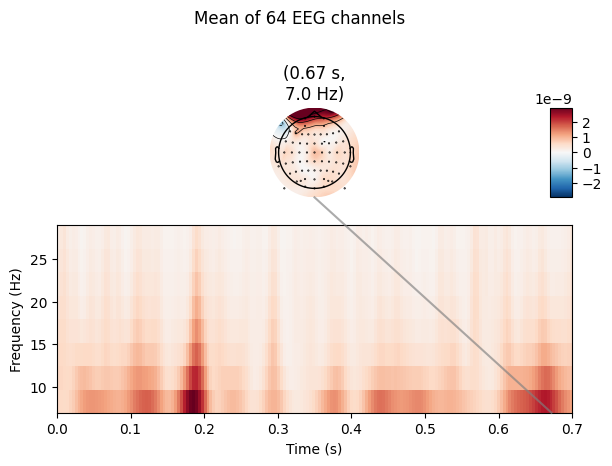

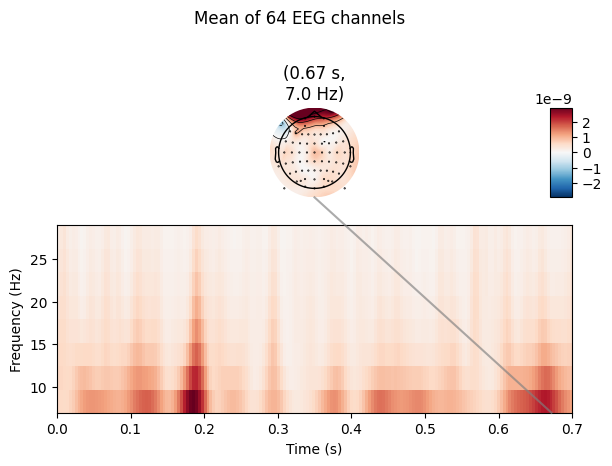

In [44]:
test_data= data[1][2][1]
test_data= np.reshape(test_data,(1,64,176))
test_data= mne.EpochsArray(test_data,info=info,verbose=0)
frequencies = np.arange(7, 30, 3)
n_cycles = freqs
wt= mne.time_frequency.tfr_morlet(test_data,freqs=frequencies,n_cycles=1)
wt[0].plot_joint()

In [22]:
test_data.shape

AttributeError: 'EpochsArray' object has no attribute 'shape'

In [8]:
def psd_gen(sub_data, cl_level, fmin,fmax):
    data=sub_data[cl_level]
    sub_psd=[]
    for i in (range(data.shape[0])):
        # Get single trial data into the right shape
        single_trial = np.reshape(data[i],(1,64,176))
        single_trial= mne.EpochsArray(single_trial,info=info,verbose=0)
        
        # Get Mean psd
        psd,freq= mne.time_frequency.psd_welch(single_trial, fmin= fmin, fmax=fmax,n_fft=176,verbose=0)
        mean_psd= np.average(psd,axis=2).flatten()
        sub_psd.append(mean_psd)
    return np.array(sub_psd)

In [9]:
theta=[np.concatenate([psd_gen(data[sub],2,1,3) for sub in tqdm(data)]),
       np.concatenate([psd_gen(data[sub],4,1,3) for sub in tqdm(data)]),
       np.concatenate([psd_gen(data[sub],6,1,3) for sub in tqdm(data)]),
       np.concatenate([psd_gen(data[sub],8,1,3) for sub in tqdm(data)])]

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.27it/s]


In [13]:
import pandas as pd
cls=[[1]*theta[0].shape[0],[2]*theta[1].shape[0],
    [3]*theta[2].shape[0],[4]*theta[3].shape[0]]
x=pd.DataFrame(np.concatenate(theta))
y=pd.DataFrame(np.concatenate(cls))
x.insert(64, "class", y, True)

In [14]:
path="/media/kashraf/Elements/Dissertation/data/preprocessed/visual/"
x.to_csv(os.path.join(path,"psd_data_noisy","delta_psd.csv"))

In [15]:
t=data[1][2][0]
single_trial = np.reshape(t,(1,64,176))
single_trial= mne.EpochsArray(single_trial,info=info,verbose=0)
        
        # Get Mean psd
psd,freq= mne.time_frequency.psd_welch(single_trial,n_fft=176,verbose=0)

In [16]:
info

<Info | 18 non-empty fields
    bads : list | 0 items
    ch_names : list | FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, ...
    chs : list | 64 items (EEG: 64)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : Digitization | 64 items (64 EEG)
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 125.0 Hz
    meas_date : NoneType | unspecified
    nchan : int | 64
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 250.0 Hz
    subject_info : dict | 5 items
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneTy

In [17]:
raw

NameError: name 'raw' is not defined

In [ ]:
erp2=np.reshape(data[sub]["erp2_new"][i],(1,64,176))
        erp2=mne.EpochsArray(erp2,info=raw_data[0].info,verbose=0)
psd,freq= mne.time_frequency.psd_welch(my_data, fmin= fmin, fmax=fmax,n_fft=176,verbose=0)
    psd1= np.average(psd,axis=2).flatten()

In [93]:
/media/kashraf/Elements/Dissertation/data/preprocessed/visual

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,class
3400,3.182906e-13,5.446012e-13,5.555841e-14,5.987031e-13,5.513171e-14,9.055484e-14,1.287593e-13,3.527576e-14,1.622442e-14,2.605111e-14,...,4.695977e-15,3.515636e-15,2.273989e-15,6.994935e-15,7.110321e-15,3.089267e-15,2.504164e-15,5.899028e-15,4.365867e-15,4
3401,3.700316e-14,1.330623e-14,3.929696e-14,1.691940e-13,6.400756e-15,1.710860e-14,7.949271e-15,5.528005e-15,5.039650e-15,1.132187e-14,...,3.589049e-15,4.653022e-15,8.724664e-16,5.427833e-15,2.067062e-15,1.041086e-14,1.860768e-15,3.022737e-15,4.387830e-15,4
3402,7.464038e-13,2.389579e-12,9.236113e-13,3.211994e-13,7.381296e-13,2.552547e-14,4.883757e-14,8.101004e-15,2.431237e-14,6.748553e-14,...,5.658666e-15,1.141584e-15,2.896776e-15,2.057829e-15,1.181238e-14,9.996800e-15,6.085762e-15,1.542401e-15,5.062728e-16,4
3403,4.152875e-14,1.572345e-13,8.355055e-14,8.673372e-14,1.316308e-13,1.958054e-14,1.441905e-13,2.090438e-14,3.168538e-15,1.406062e-14,...,1.387421e-15,3.295463e-15,2.089915e-15,1.204507e-15,1.134461e-15,5.233327e-16,1.666140e-15,2.016404e-15,2.196254e-15,4
3404,2.413955e-14,7.330115e-14,7.179467e-14,1.047241e-13,7.023949e-14,3.614002e-14,1.509249e-13,2.311021e-14,5.048912e-15,1.419031e-14,...,2.111638e-15,6.676561e-16,2.648078e-15,6.712146e-16,1.479925e-15,1.714872e-15,1.529399e-15,1.192563e-15,1.095795e-15,4
